This Notebook contains an example of using the given VaLLA implementation over 1D regression datasets.

# Imports

In [1]:
# Notebook reload options
%load_ext autoreload
%autoreload 2

In [2]:

# Global Imports
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader
import sys
from time import process_time as timer
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.cluster.vq import kmeans2

# Local Imports
sys.path.append("..")
from utils.pytorch_learning import fit_map, fit, forward
from src.valla import VaLLARegression, VaLLARegressionBackend
from src.ella import ELLA_Regression
from utils.models import get_mlp, create_ad_hoc_mlp
from laplace import Laplace

from utils.dataset import get_dataset

# Experimental settings

Theese are the parameters that determine the experiments. Most of these values are set to their default value. Please refer to `utils/process_flass.py` to know more about each parameter.

In [3]:
params = {
        "num_inducing": 20,
        "bnn_structure": [50, 50],
        "MAP_lr": 0.001,
        "MAP_iterations": 3000,
        "lr": 0.001,
        "iterations": 20000,
        "activation": torch.nn.Tanh,
        "device": "cpu",
        "dtype": torch.float64,
        "seed": 2147483647,
        "bb_alpha": 0,
        "prior_std": 1,
        "ll_std": 1
}

Set seed for reproductibility.

In [4]:
torch.manual_seed(params["seed"])

Load Dataset and desired split.

In [5]:
dataset = get_dataset("synthetic2")
train_dataset, train_test_dataset, test_dataset = dataset.get_split()

Number of samples:  400
Input dimension:  1
Label dimension:  1
Labels mean value:  0
Labels standard deviation:  1


Create Data loaders for training and test partitions.

In [6]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
train_test_loader = DataLoader(train_test_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# MAP Learning

In [7]:
f = get_mlp(
    train_dataset.inputs.shape[1],
    train_dataset.targets.shape[1],
    params["bnn_structure"],
    params["activation"],
    device=params["device"],
    dtype=params["dtype"],
)

# Define optimizer and compile model
opt = torch.optim.Adam(f.parameters(), lr=params["MAP_lr"])
criterion = torch.nn.MSELoss()

# Set the number of training samples to generate
# Train the model
start = timer()

loss = fit_map(
    f,
    train_loader,
    opt,
    criterion=torch.nn.MSELoss(),
    use_tqdm=True,
    return_loss=True,
    iterations=12000,
    device=params["device"],
)
end = timer()

Sequential(
  (0): Linear(in_features=1, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=1, bias=True)
)


Training :   1%|          | 141/12000 [00:00<00:25, 466.33 iteration/s]

Training : 100%|██████████| 12000/12000 [00:20<00:00, 586.75 iteration/s]


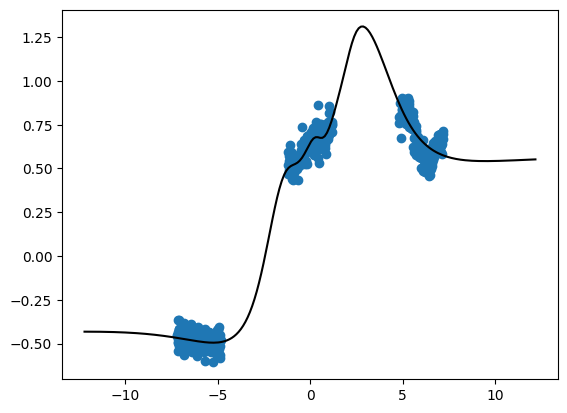

In [8]:

plt.scatter(train_dataset.inputs, 
                train_dataset.targets, 
                label="Training points")



sort = np.argsort(test_dataset.inputs.flatten())


plt.plot(
    test_dataset.inputs.flatten()[sort],
    f(torch.tensor(test_dataset.inputs)).detach().numpy().flatten()[sort],
    label="Predictions",
    color="black",
)
plt.show()

In [9]:
# 'all', 'subnetwork' and 'last_layer'
subset = "all"
# 'full', 'kron', 'lowrank' and 'diag'
hessian = "full"
X = test_dataset.inputs
la = Laplace(f, "regression", subset_of_weights=subset, hessian_structure=hessian)
la.fit(train_loader)

log_prior, log_sigma = torch.ones(1, requires_grad=True, dtype=params["dtype"]), torch.ones(
    1, requires_grad=True, dtype = params["dtype"]
)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in tqdm(range(100)):
    hyper_optimizer.zero_grad()
    neg_marglik = -la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

prior_std = np.sqrt(1 / np.exp(log_prior.detach().numpy())).item()
log_variance = 2*log_sigma.detach().numpy().item()



100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


In [10]:
print("Optimal GP prior std: ", prior_std)
print("Optimal GP likelihoog log variance: ", log_variance)

Optimal GP prior std:  2.157249656053849
Optimal GP likelihoog log variance:  -5.534579457457951


In [11]:
def distribution_plot(model_predictive, name = None, Z, inducing_locations):
    plt.rcParams["pdf.fonttype"] = 42
    plt.figure(figsize=(16,7))
    mean, var = model_predictive(torch.tensor(test_dataset.inputs, dtype = params["dtype"]))
    mean = mean.detach().numpy()
    var = var.detach().numpy() + np.exp(log_variance)
    std = np.sqrt(var).flatten()

    gpmean, gpvar = la._glm_predictive_distribution(torch.tensor(test_dataset.inputs, dtype = params["dtype"]))
    gpmean = gpmean.detach().numpy()
    gpvar = gpvar.detach().numpy() + np.exp(log_variance)
    gpstd = np.sqrt(gpvar).flatten()

    sort = np.argsort(test_dataset.inputs.flatten())

    fig = plt.scatter(train_dataset.inputs, 
                    train_dataset.targets, 
                    color = "black")

    plt.plot(
        test_dataset.inputs.flatten()[sort],
        mean.flatten()[sort],
        color="cornflowerblue",
    )
    plt.fill_between(
        test_dataset.inputs.flatten()[sort],
        mean.flatten()[sort] - 2 * std[sort],
        mean.flatten()[sort] + 2 * std[sort],
        alpha=0.2,
        color="cornflowerblue",
    )

    plt.plot(
        test_dataset.inputs.flatten()[sort],
        gpmean.flatten()[sort],
        color="tomato",
        linestyle = "--",
    )
    plt.plot(
        test_dataset.inputs.flatten()[sort],
        gpmean.flatten()[sort] - 2* gpstd.flatten()[sort],
        color="tomato",
        linestyle = "--",
    )
    plt.plot(
        test_dataset.inputs.flatten()[sort],
        gpmean.flatten()[sort] + 2* gpstd.flatten()[sort],
        color="tomato",
        linestyle = "--",
    )
    #plt.axis('off')
    plt.ylim(-2.5 ,5)

    plt.scatter(Z.flatten(), np.ones(20) * 4.5, marker = "x", color = "orange", label = "Initial Inducing Points")
    plt.scatter(inducing_locations.detach().numpy().flatten(), np.ones(20) * -2, marker = "o", 
                color = "orange", label = "Optimized Inducing Points")

    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig("../demos/plots/" + name+ ".pdf", format="pdf", bbox_inches='tight')
    plt.show()

# ELLA

In [12]:
Ms = [5, 10, 20, 50]

Training : 100%|██████████| 4/4 [00:00<00:00, 350.38iteration/s]


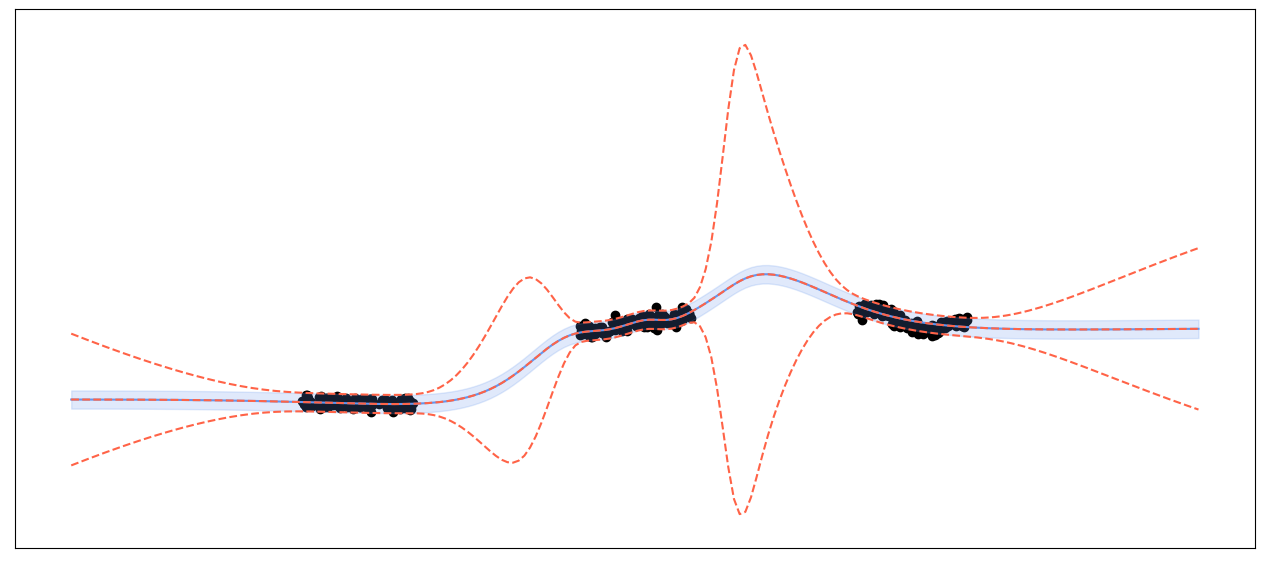

Training : 100%|██████████| 4/4 [00:00<00:00, 262.27iteration/s]


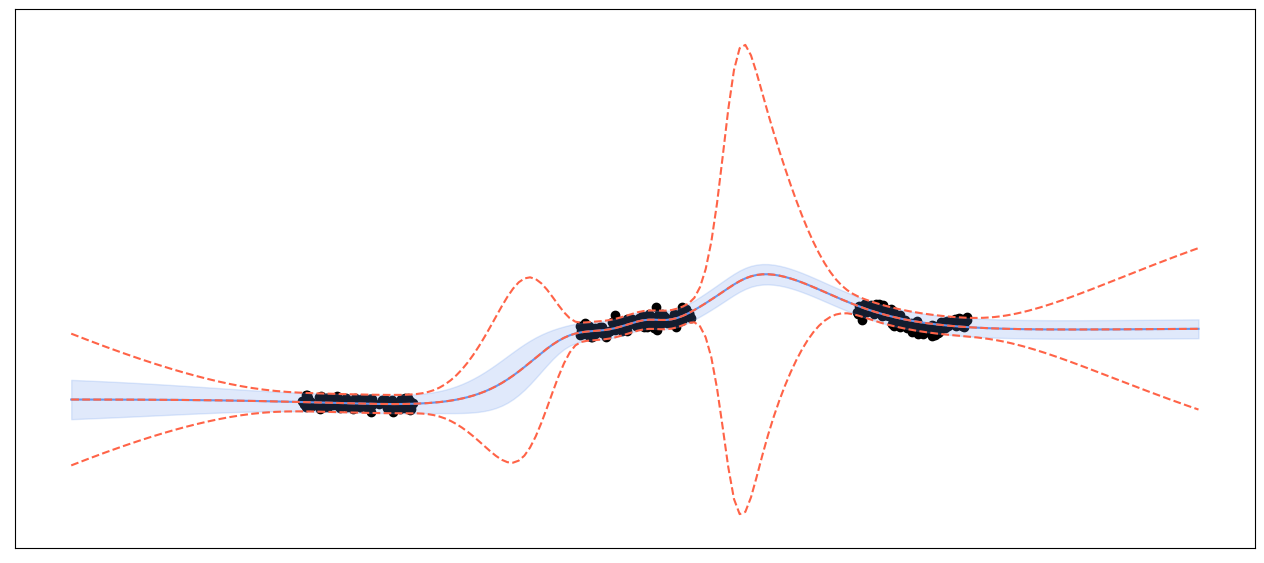

Training : 100%|██████████| 4/4 [00:00<00:00, 369.12iteration/s]


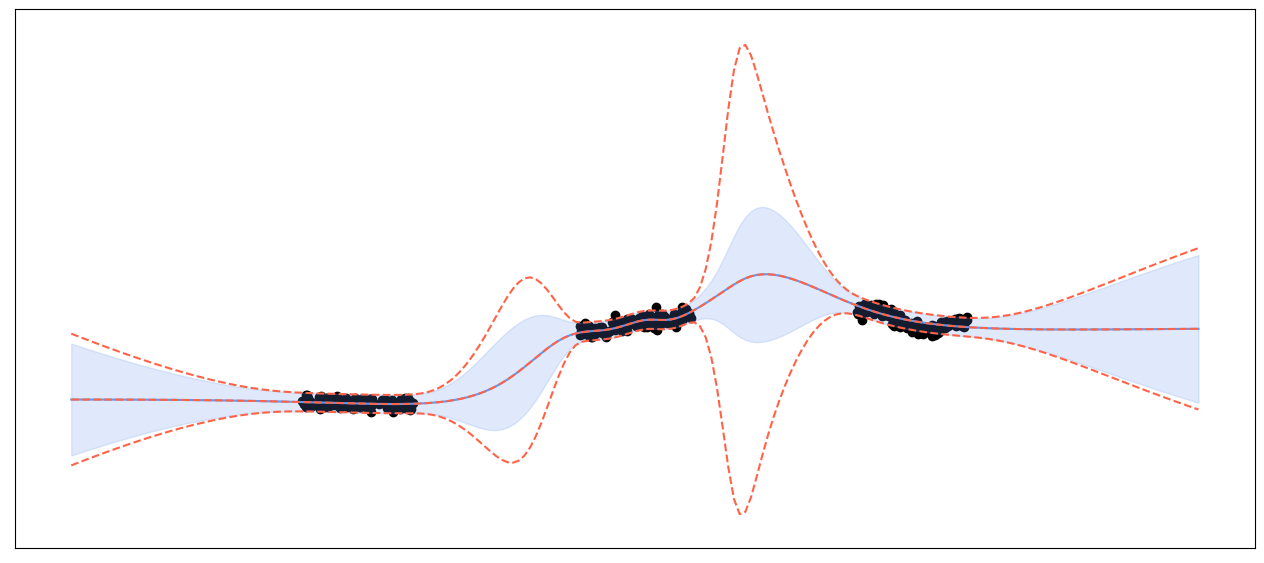

Training : 100%|██████████| 4/4 [00:00<00:00, 324.02iteration/s]


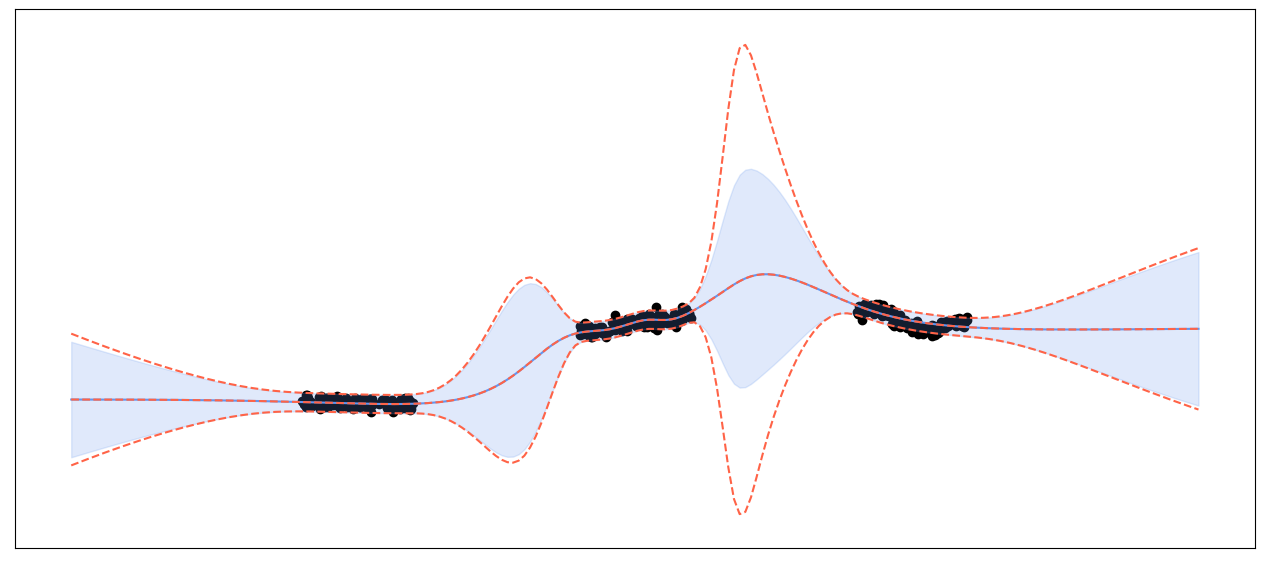

In [13]:
for m in Ms:
    ella = ELLA_Regression(
        create_ad_hoc_mlp(f),
        f.output_size,
        m,
        min(m, 20),
        prior_std=prior_std,
        log_variance = log_variance,
        seed=params["seed"],
        y_mean=train_dataset.targets_mean,
        y_std=train_dataset.targets_std,
        device=params["device"],
        dtype=params["dtype"],
    )
    ella.fit_loader_val(
            torch.tensor(train_dataset.inputs, 
                         device=params["device"], 
                         dtype=params["dtype"]),
            torch.tensor(train_dataset.targets,
                         device=params["device"], 
                         dtype=params["dtype"]),
            train_loader,
            val_loader = None,
            verbose = True,
        )
    distribution_plot(ella.predict_f, "ELLA_M={}".format(m))

# VaLLA

Define DVIP model.

Backend or not can be used, in case of using the backend change `VaLLARegression` for `VaLLARegressionBackpack` and un-comment the backend line.

In [14]:
from src.backpack_interface import BackPackInterface
backend = BackPackInterface(f, train_dataset.output_dim)

Initializing inducing classes with 1 different classes


Training :   0%|          | 12/30000 [00:00<04:19, 115.68 iteration/s]

Training : 100%|██████████| 30000/30000 [03:47<00:00, 131.63 iteration/s]


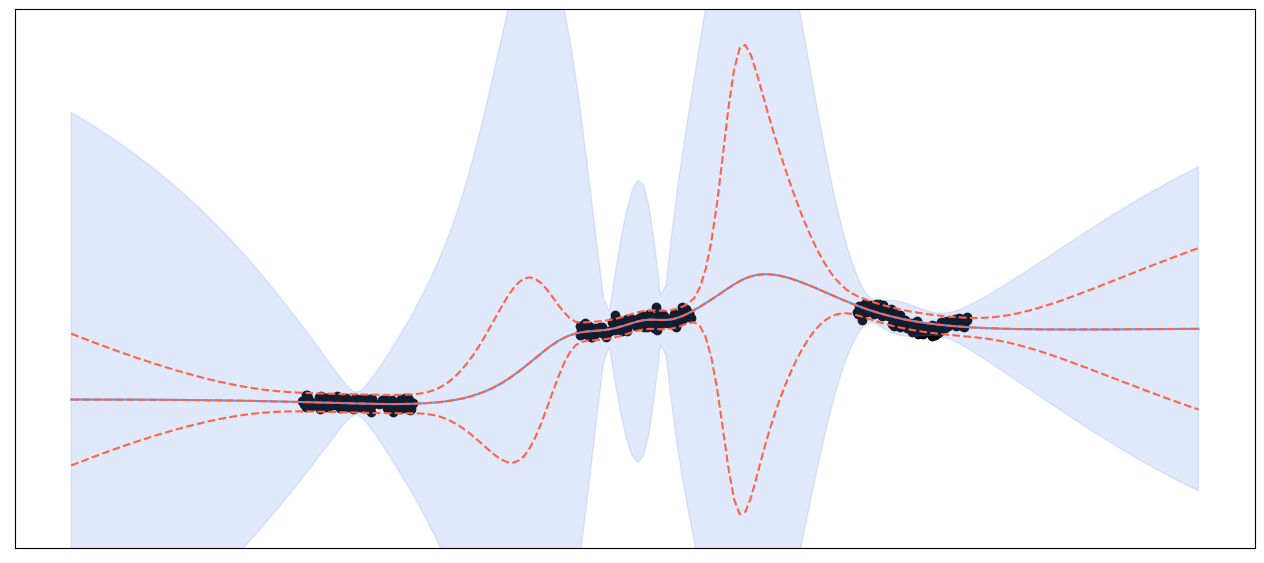

Initializing inducing classes with 1 different classes


Training : 100%|██████████| 30000/30000 [03:50<00:00, 129.97 iteration/s]


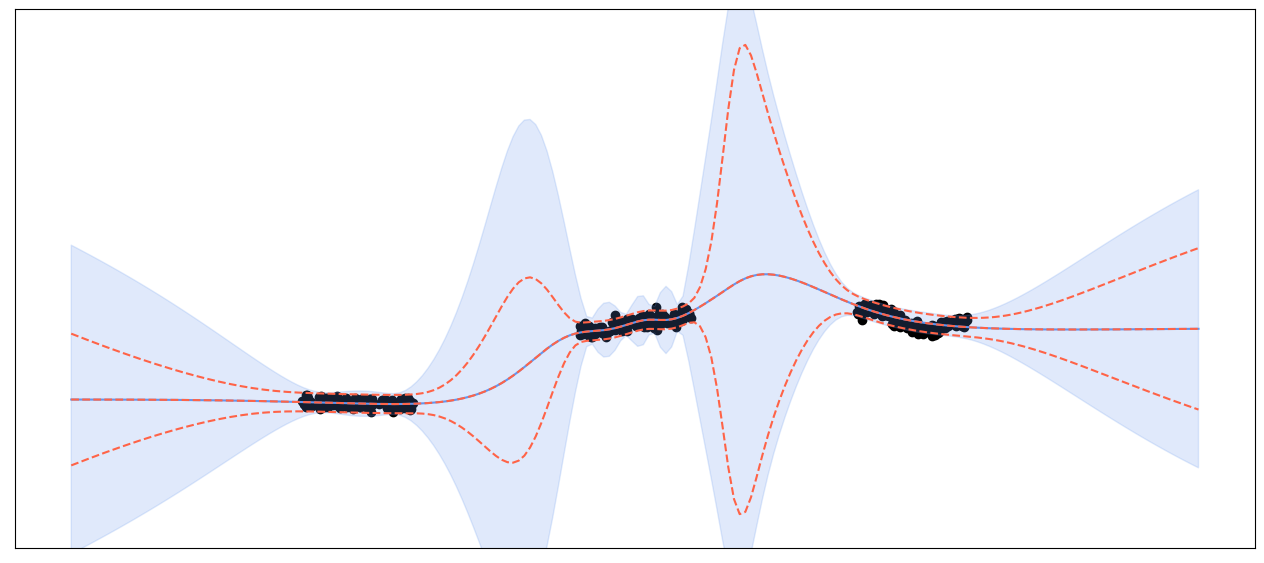

Initializing inducing classes with 1 different classes


Training : 100%|██████████| 30000/30000 [03:59<00:00, 125.09 iteration/s]


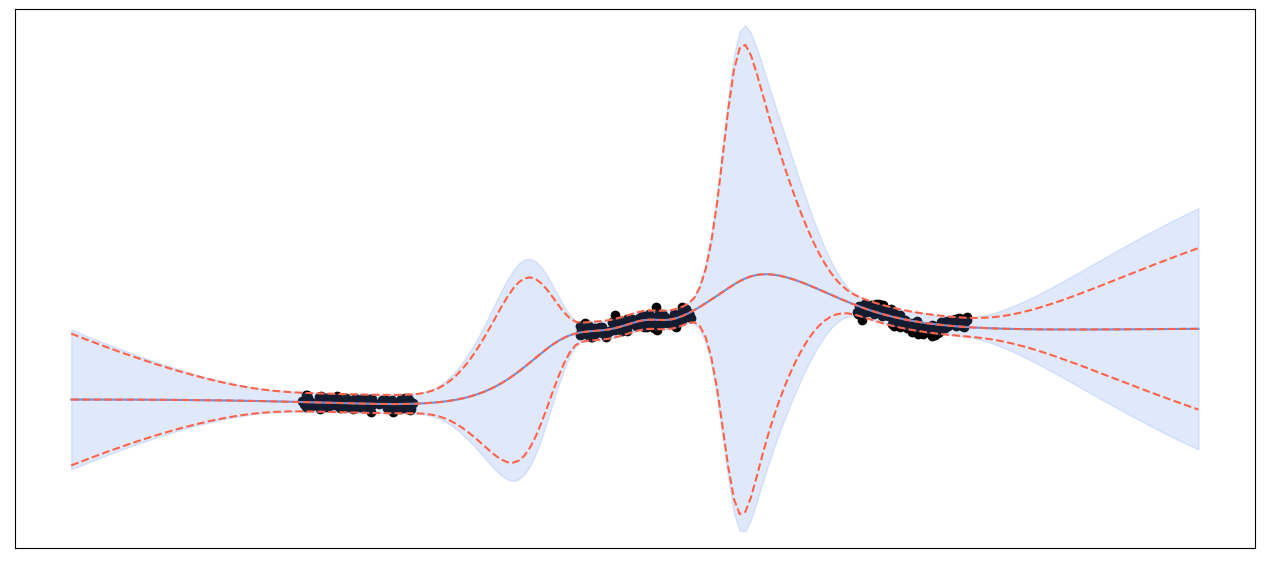

Initializing inducing classes with 1 different classes


Training : 100%|██████████| 30000/30000 [04:40<00:00, 107.10 iteration/s]


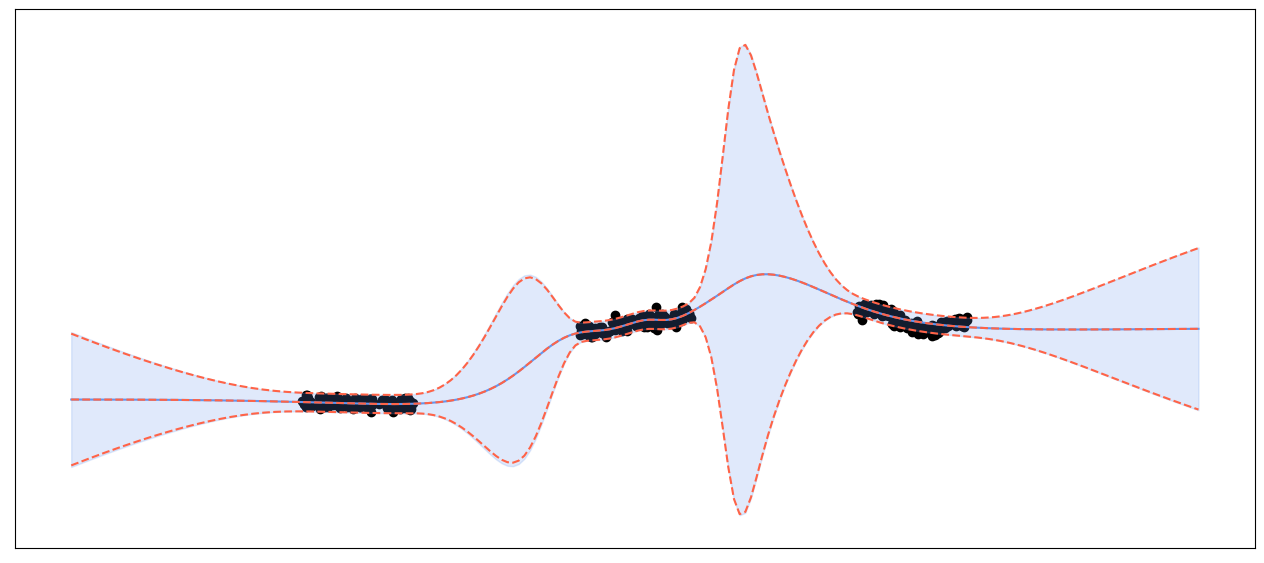

In [15]:
for m in Ms:
    Z = kmeans2(train_dataset.inputs, m, 
            minit="points", seed=params["seed"])[0]
    valla = VaLLARegression(
        create_ad_hoc_mlp(f),
        Z,
        alpha=params["bb_alpha"],
        prior_std=prior_std,
        log_variance=log_variance,
        #backend = backend,
        num_data=train_dataset.inputs.shape[0],
        output_dim=1,
        track_inducing_locations=True,
        y_mean=train_dataset.targets_mean,
        y_std=train_dataset.targets_std,
        device=params["device"],
        dtype=params["dtype"],
    )
    valla.freeze_ll()
    valla.freeze_prior()
    opt = torch.optim.Adam(valla.parameters(), lr=0.001)

    loss = fit(
        valla,
        train_loader,
        opt,
        use_tqdm=True,
        return_loss=True,
        iterations=30000,
        device=params["device"],
    )
    distribution_plot(valla.predict_f, "VaLLA_M={}_fixed".format(m))